<a href="https://colab.research.google.com/github/woojin9605/Practice/blob/main/Classifier_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CIFAR-10 Classifier

VGG-16을 CIFAR-10데이터에 맞게 레이어 수정하여 구현

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load train dataset

Num_Train = 49000
BatchSize = 64

transform = T.Compose([
              T.ToTensor(),
              T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
]) # 데이터 정규화

cifar10_train = dset.CIFAR10(root='./CIFAR-10',train=True,
                             download=True,transform=transform)
loader_train = DataLoader(cifar10_train,batch_size=BatchSize,
                          sampler=sampler.SubsetRandomSampler(range(Num_Train)))

cifar10_val = dset.CIFAR10('./CIFAR-10/',train=True,
                           download=True,transform=transform)
loader_val = DataLoader(cifar10_val,batch_size=BatchSize,
                          sampler=sampler.SubsetRandomSampler(range(Num_Train,50000)))

cifar10_test = dset.CIFAR10('./CIFAR-10/',train=False,
                           download=True,transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

classes = ('plane','car','bird','cat',
           'deer','dog','frog','horse','ship','truck')

dtype = torch.float32
device = torch.device('cuda')

Extracting ./CIFAR-10/cifar-10-python.tar.gz to ./CIFAR-10
Files already downloaded and verified
Files already downloaded and verified


In [8]:
# model architecture 및 optimizer 정의

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

model = None
optimizer = None
learning_rate = 1e-4
betas = [0.9, 0.999]

layers_key = [64, 64, 'M', 128, 128, 256, 256, 256, 'M', 512, 512, 512, 512, 512, 512, 'M']
layers = [] # 대부분의 레이어는 유지. MaxPool 레이어만 제거
in_channels = 3

for i in layers_key: # generate nn.Sequential layers
  if i == 'M':
    layers += [nn.MaxPool2d(2,2)]
  else:
    layers += [nn.Conv2d(in_channels,i,3,padding=1), nn.BatchNorm2d(i), nn.ReLU()]
    in_channels = i

#print(layers)

model = nn.Sequential(
    *layers,
    Flatten(),
    nn.Linear(512*4*4,4096),
    nn.ReLU(),
    nn.Dropout(), # default p = 0.5
    nn.Linear(4096,4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096,10)
)

print(model)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()
  (16): Conv2d(256, 256

In [4]:
# training model

model = model.to(device=device)
print_every = 1000
epochs = 10
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.8) # lr decay

for e in range(epochs): # training
  for t,(x,y) in enumerate(loader_train):
    model.train() #model contain batchnorm, dropout etc. 모델에게 train상태임을 알려줌
    x = x.to(device=device, dtype=dtype)
    y = y.to(device=device, dtype=torch.long)

    scores = model(x)
    loss = F.cross_entropy(scores,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % print_every == 0:
      print('iter %d, loss = %.4f' % (t, loss.item()))
  lr_sche.step()

print('training finished, loss = %.4f' % loss.item())

iter 0, loss = 2.3417
iter 0, loss = 0.7029
iter 0, loss = 0.5959
iter 0, loss = 0.5335
iter 0, loss = 0.4481
iter 0, loss = 0.2088
iter 0, loss = 0.1411
iter 0, loss = 0.1702
iter 0, loss = 0.2533
iter 0, loss = 0.2021
training finished, loss = 0.4161


In [5]:
# accuracy test

model.eval()
num_correct = 0
num_samples = 0

for (x,y) in loader_test:
      x = x.to(device=device, dtype=dtype)
      y = y.to(device=device, dtype=torch.long)

      scores = model(x)
      _, predicts = torch.max(scores,dim=1)

      num_correct += torch.sum(predicts == y)
      num_samples += predicts.size(0)

acc = float(num_correct) / num_samples
print('correct : %d / %d , acc (%.2f)' % (num_correct,num_samples,100*acc))

correct : 8411 / 10000 , acc (84.11)


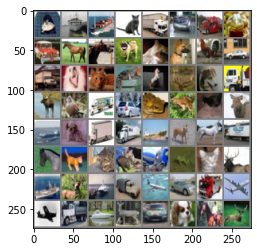

Ground_Truth :    cat ship ship  cattruck  cartruck frog  carhorsehorse  dog  cat  dog bird  cartruck  dog  cat  cathorse deer  dogtruck deer birdtruck  car frog frog  cat deer ship  dogtrucktruck ship  doghorsetruckhorse  cat  cat  cattruck frog  cat deer ship deer shiptruckplane  cartruckplaneplanetruck ship deer  car  doghorse deer
Predicted    :    cat ship ship  cattruck  cartruck frog  carhorsehorse  dog  cat  dog bird  cartruck  dog  cat  cathorse deer  dogtruck deer birdtruck  car frog frog  cat deer ship  dogtrucktruck ship  doghorsetruckhorse  cat  cat  cattruck frog  cat deer ship deer shiptruckplane  cartruckplaneplanetruck ship deer  car  doghorse deer


In [7]:
# compare ground_truth and predicted

def imshow(img):
  img = img / 2+0.5 #unnormalize
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1,2,0)))
  plt.show()

dataiter = iter(loader_val)
x, y = dataiter.next()

imshow(torchvision.utils.make_grid(x))
x = x.to(device=device, dtype=dtype)
y = y.to(device=device, dtype=torch.long)

print('Ground_Truth : ',''.join('%5s' % classes[y[j]] for j in range(BatchSize)))

scores = model(x)
_, predicted = torch.max(scores,1)
print('Predicted    : ',''.join('%5s' % classes[y[j]] for j in range(BatchSize)))